# Configuring system and starting server and client dockers

This can be done by running this command on the SMuRF server:

You need to run this in a terminal with X-windows so the server gui can come up.  I typically do this in a VNC session.  On the SMuRF server you can check if a VNC session is running on the command line like this:

This means there's a server up and running on the SMuRF server port 5902, which is the default port I usually start VNC sessions on.  If you don't see any VNC servers up, you can start it by ssh'ing to the machine and entering this command on the command line to start a server on port 5902:

Once the VNC server is up, you can forward this port from the SMuRF server to your machine via ssh like this:

After which you should be able to connect to the VNC server using your viewer by pointing your viewer at `localhost:5902`.

If you've just run the `rfsochammer` command in the VNC session, when it completes, you should get handed a `pysmurf` session in the terminal you ran `rfsochammer` from, and the server gui should pop up in the VNC session, which looks like this:

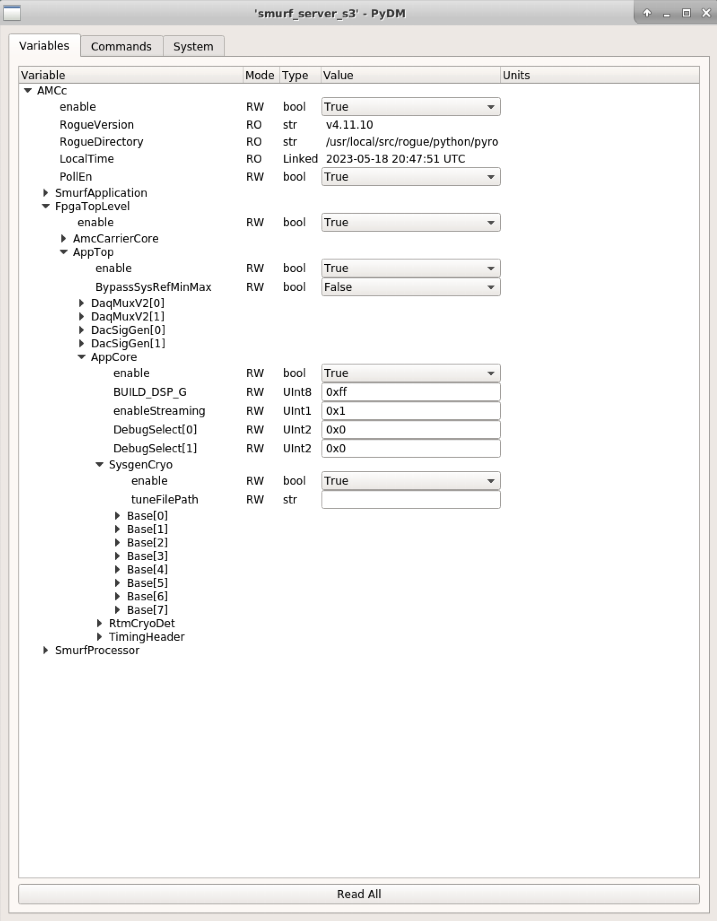

Currently, `rfsochammer` is configured to just start the server and client dockers, but not to do anything else (like run `setDefaults`.  From here, you can either continue to interface with the system through the pysmurf session that comes up in the terminal you ran `rfsochammer` in, or can control it through a jupyter notebook interface like I'm doing here.

The SMuRF server should start in a docker called `smurf_server_s3`.  Here's what it should look like if it started successfully (you can see this by running `docker logs smurf_server_s3` in a terminal session running outside the dockers on the SMuRF server):

# Connecting to the jupyter notebook interface

The jupyter notebook server runs in another docker.  I created an alias to start it if it's not already up (or do nothing if it is) called `start_jupyter_rfsoc` on smurf-srv06.  Running this should start a jupyter server in a docker named `jupyter-rfsoc` running on port 8000 of the SMuRF server.  The docker logs should look like this if the server was just brought up (you can see this by running `docker logs jupyter-rfsoc` in a terminal session running outside the dockers on the SMuRF server):

You can use the same ssh port forwarding trick above to connect to the jupyter server from your local machine.  So e.g. to forward both the VNC and jupyter server ports to your machine via ssh, ssh into the SMuRF server like this from your machine:

After which you'll be able to access the jupyter server on your machine's port 8000 by entering `localhost:8000` into your browser.

# Starting a pysmurf instance

If the SMuRF server is up, you can create a pysmurf control instance like this (I'm also loading some dependencies we often use):

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import numpy as np
from matplotlib import cm
from scipy.signal import welch,periodogram
import pandas as pd
import glob
from scipy.optimize import curve_fit
from scipy import signal

import pysmurf.client
import matplotlib.pylab as plt
import numpy as np
import sys
import os
epics_prefix="smurf_server_s3"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/lab1/experiment_lab1_rfsoc.cfg")
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

[ 2023-05-18 21:28:36 ]  ERROR : band 0 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 1 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 2 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 3 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 4 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 5 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 6 is present in pysmurf cfg file, but its bay is not enabled!
[ 2023-05-18 21:28:36 ]  ERROR : band 7 is present in pysmurf cfg file, but its bay is not enabled!


We'll interact with the system through this `S` object from here on.

# Dumping versions

What versions of everything are we running?  This is useful to do at the top of any notebook to track what versions were used:

In [13]:
pysmurf.__version__

'7.2.0+5.gdfc39a5b.dirty'

What pysmurf branch are we running?

In [6]:
!git branch

  main
* zcu208-devel


In [7]:
S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True)

'v4.11.10'

In [8]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True)

'7.2.0'

In [3]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:StartupArguments', as_string=True)

'-g -w smurf_server_s3 -d /tmp/fw/defaults_rfsoc_zcu208.yml -e smurf_server_s3 --disable-bay0 --disable-bay1 -a 10.0.1.103 -z /tmp/fw/rogue_MicrowaveMuxBpEthGen2_v1.1.0_rfsoc.zip'

In [15]:
S.get_fpga_git_hash_short()

'3c8e661'

# Loading defaults

If system was just powered on or defaults changed, need to at least load defaults.  Do that like this (`write_log=True` just increases the amount of printout to help with debugging):

In [5]:
S.setup()

[ 2023-05-18 21:30:07 ]  System already configured, but will configure again since force_configure=True.
[ 2023-05-18 21:30:07 ]  Setting up...
[ 2023-05-18 21:30:07 ]  caput smurf_server_s3:AMCc:ReadAll 1
[ 2023-05-18 21:30:11 ]  Waiting 20.00 seconds after...
[ 2023-05-18 21:30:31 ]  Done waiting.
[ 2023-05-18 21:30:31 ]  caget smurf_server_s3:AMCc:SmurfApplication:SmurfVersion
[ 2023-05-18 21:30:31 ]  7.2.0
[ 2023-05-18 21:30:31 ]  caput smurf_server_s3:AMCc:setDefaults 1
[ 2023-05-18 21:30:45 ]  caget smurf_server_s3:AMCc:SmurfApplication:ConfiguringInProgress
[ 2023-05-18 21:30:45 ]  False
[ 2023-05-18 21:30:45 ]  caget smurf_server_s3:AMCc:SmurfApplication:SystemConfigured
[ 2023-05-18 21:30:45 ]  True
[ 2023-05-18 21:30:45 ]  System configuration finished after 13 seconds. The final state was True.
[ 2023-05-18 21:30:45 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSwapIn 0
[ 2023-05-18 21:30:45 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:A

[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:iqSwapIn 0
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:iqSwapOut 0
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:refPhaseDelay 6
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:refPhaseDelayFine 16
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:lmsDelay 24
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:lmsGain 5
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:trigRstDly 15
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[3]:feedbackEnable 1
[ 2023-05-18 21:30:49 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base

[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:gradientDescentAverages 1
[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:gradientDescentConvergeHz 500.0
[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:gradientDescentStepHz 1000.0
[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:gradientDescentMomentum 1
[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:gradientDescentBeta 0.0
[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:etaScanAverages 1
[ 2023-05-18 21:30:51 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[6]:CryoChannels:etaScanDelF 5000
[ 2023-05-18 21:30:51 ]  caput smurf_server_

True

If successful, returns `True` and docker logs for the server should look like this:

The system should now be configured and ready to use!

# Loading a waveform into one of the DACs

Here's how to play a tone file using pysmurf:

In [20]:
S.play_tone_file(1,tone_file='/data/smurf_data/tone_files/singletone2p4mhz.csv',write_log=True)

[ 2023-05-18 21:42:03 ]  Loading tone file : /data/smurf_data/tone_files/singletone2p4mhz.csv
[ 2023-05-18 21:42:03 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DacSigGen[0]:LoadCsvFile /data/smurf_data/tone_files/singletone2p4mhz.csv
[ 2023-05-18 21:42:03 ]  Playing tone file /data/smurf_data/tone_files/singletone2p4mhz.csv on band 1
[ 2023-05-18 21:42:03 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[1]:waveformSelect 1


You should see this in the SMuRF server logs if the file was correctly loaded:

To read back the DAC, can run e.g.

[ 2023-05-18 21:38:20 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2023-05-18 21:38:21 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 1


/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1708: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


[ 2023-05-18 21:38:22 ]  DAC plot saved to /data/smurf_data/20230518/1684445316/plots/1684445901_dac1.png
[ 2023-05-18 21:38:22 ]  Saving raw dac data to /data/smurf_data/20230518/1684445316/outputs/1684445901_dac1


array([-29412.+14443.j, -29049.+15160.j, -28668.+15868.j, ...,
       -30395.+12240.j, -30086.+12982.j, -29758.+13716.j])

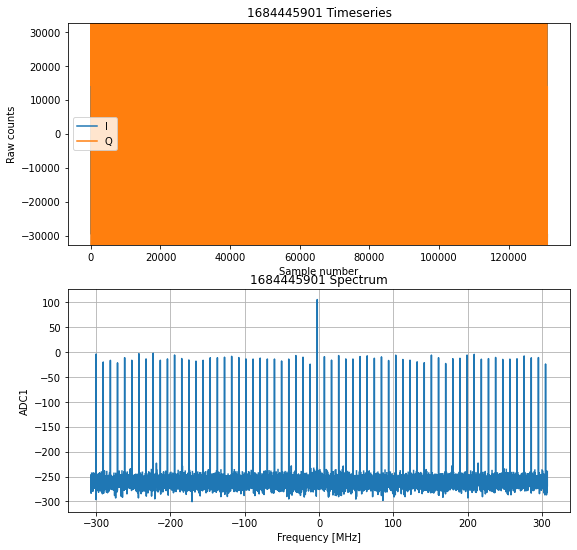

In [10]:
S.read_dac_data(data_length=2**16, band=1, make_plot=True, show_plot=True)

And to read the ADC:

[ 2023-05-18 21:42:08 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2023-05-18 21:42:08 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 1
[ 2023-05-18 21:42:08 ]  ADC plot saved to /data/smurf_data/20230518/1684445316/plots/1684446128_adc1.png
[ 2023-05-18 21:42:08 ]  Saving raw adc data to /data/smurf_data/20230518/1684445316/outputs/1684446128_adc1


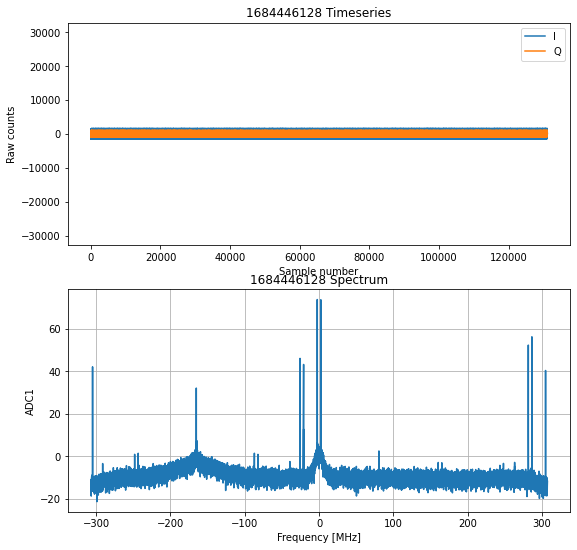

In [21]:
adcdata=S.read_adc_data(data_length=2**16, band=1, make_plot=True, show_plot=True)

To turn off playing the loaded tone file, can do this:

In [17]:
S.set_waveform_select(1,0)